In [206]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import pickle

# get cleaned data
file = open('../data/data_cleaned.save', 'rb')
df, X, y, groups = pickle.load(file)
file.close()

file = open('../data/preprocessor.save', 'rb')
preprocessor = pickle.load(file)
file.close()

file = open('../results/rf_best_params.save', 'rb')
rf_best_params = pickle.load(file)
file.close()

for params in rf_best_params:
    print(params)

{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 3, 'randomfo

In [207]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# train final model for 100 different random states
nr_states = 100

final_models = []
final_train_data = []
final_test_data = []
final_predictions = []
final_scores = []
baseline_scores = []


for r in range(nr_states):
        
    r = r+9
    
    le_y = LabelEncoder()
    y_prep = le_y.fit_transform(y)
    y_prep = pd.DataFrame(data = y_prep, columns = ['CDR'])

    # create a test set based on groups
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=r)
    for i_train, i_test in splitter.split(X, y_prep, groups):
        X_train, y_train, groups_train = X.iloc[i_train], y_prep.iloc[i_train], groups.iloc[i_train]
        X_test, y_test, groups_test = X.iloc[i_test], y_prep.iloc[i_test], groups.iloc[i_test]
        
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    y_train = np.reshape(np.array(y_train), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()
        
    pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)
        
    rf = RandomForestClassifier(max_depth=3, max_features=0.75, random_state=r)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    baseline_score = np.sum(y_test == 0)/len(y_test)
    
    final_models.append(rf)
    final_train_data.append((X_train, y_train))
    final_test_data.append((X_test, y_test))
    final_predictions.append(y_pred)
    final_scores.append(score)
    baseline_scores.append(baseline_score)

#     print(baseline_score)
#     print(rf.feature_importances_)


In [242]:
# save the output
file = open('../results/final_models.save', 'wb')
pickle.dump((final_models, final_predictions, final_scores, baseline_scores),file)
file.close()

file = open('../data/final_data.save', 'wb')
pickle.dump((final_train_data, final_test_data),file)
file.close()

# test scores mean and stdev
test_mean = np.mean(final_scores)
test_stdev = np.std(final_scores)

# baseline scores mean and stdev
base_mean = np.mean(baseline_scores)
base_stdev = np.std(baseline_scores)

# stdevs above baseline
stdevs_above_base = (test_mean - base_mean) / test_stdev

print('Mean test score: ', test_mean)
print('Mean baseline score: ', base_mean)
print('Standard deviations above baseline: ', stdevs_above_base)


Mean test score:  0.7201390265983264
Mean baseline score:  0.5437962745065164
Standard deviations above baseline:  2.983277930701013


In [209]:
ordinal_ftrs = ['EDUC']
onehot_ftrs = ['Gender', 'SES']
minmax_ftrs = ['Age', 'MMSE', 'nWBV']
std_ftrs = ['eTIV', 'ASF']

onehot_ftrs_prep = list(pipe.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names(onehot_ftrs))

feature_names = ordinal_ftrs + onehot_ftrs_prep + minmax_ftrs + std_ftrs
# feature_names

In [212]:
from sklearn.metrics import confusion_matrix

# create normalized confusion matrix, mean of confusion matrices for each random state
cms = [confusion_matrix(final_test_data[i][1], final_predictions[i]) for i in range(len(final_test_data))]

cm_mean = np.empty(shape=(3,3))

for i in range(3):
    for j in range(3):
        cm_mean[i,j] = sum([cm[i,j] for cm in cms]) / len(cms)

cm_norm = cm_mean.astype('float') / cm_mean.sum(axis=1)[:, np.newaxis]

In [213]:
len(rf.feature_importances_)
len(feature_names)

feat_imp_mean = []
feat_imp_stdev = []

# find mean and stdev of feature importances across all random states
for i in range(len(feature_names)):
    feat = [m.feature_importances_[i] for m in final_models]
    feat_imp_mean.append(np.mean(feat))
    feat_imp_stdev.append(np.std(feat))
    
feat_imp_mean
# feat_imp_stdev


[0.03025349843387005,
 0.029603778496462847,
 0.029666164312845047,
 0.0013352374123341568,
 0.009923764782266233,
 0.005162315639861525,
 0.001476816380079106,
 0.0007293168742842596,
 0.02276322572801762,
 0.05803126359865746,
 0.6662140644705845,
 0.08293993435734777,
 0.030851008346533298,
 0.031049611166856107]

In [214]:
from sklearn.inspection import permutation_importance

perm_importances = []

# collect permutation importances for each random state
for i in range(len(final_models)):
    result = permutation_importance(final_models[i], final_test_data[i][0], final_test_data[i][1], n_repeats=10, 
                                random_state=5, n_jobs=-1)
    perm_importances.append(result.importances_mean)


In [215]:
perm_imp_mean = []
perm_imp_std = []

# calculate mean and std dev of permuation importances across all random states
for i in range(len(feature_names)):
    feat = [m[i] for m in perm_importances]
    perm_imp_mean.append(np.mean(feat))
    perm_imp_std.append(np.std(feat))

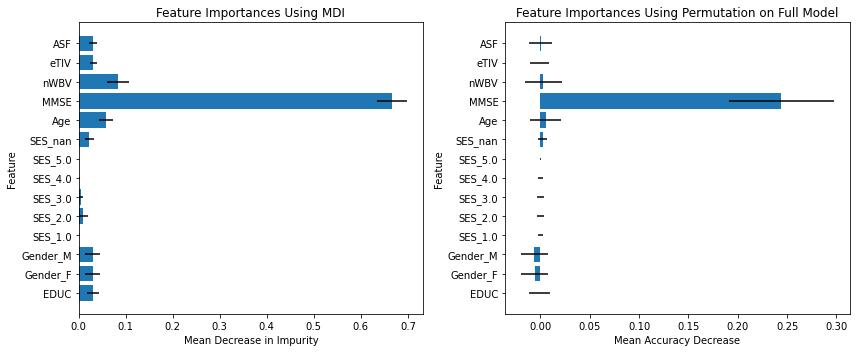

In [232]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh(feature_names, feat_imp_mean)
plt.errorbar(feat_imp_mean, feature_names, xerr=feat_imp_stdev, fmt='none', color='black' )
# plt.xlim([0.45,0.8])
plt.xlabel('Mean Decrease in Impurity')
plt.ylabel('Feature')
plt.title('Feature Importances Using MDI')

plt.subplot(1,2,2)
plt.barh(feature_names, perm_imp_mean)
plt.errorbar(perm_imp_mean, feature_names, xerr=perm_imp_std, fmt='none', color='black' )
# plt.xlim([0.45,0.8])
plt.xlabel('Mean Accuracy Decrease')
plt.ylabel('Feature')
plt.title('Feature Importances Using Permutation on Full Model')

plt.tight_layout()
plt.savefig("../figures/reportfigs/feature_importances.png", bbox_inches='tight', dpi=300)
plt.show()

In [216]:
import shap

# create the explainer object with the random forest model
explainer = shap.TreeExplainer(final_models[0])
shap_values = explainer.shap_values(final_test_data[0][0])

In [217]:
np.shape(shap_values)

(3, 78, 14)

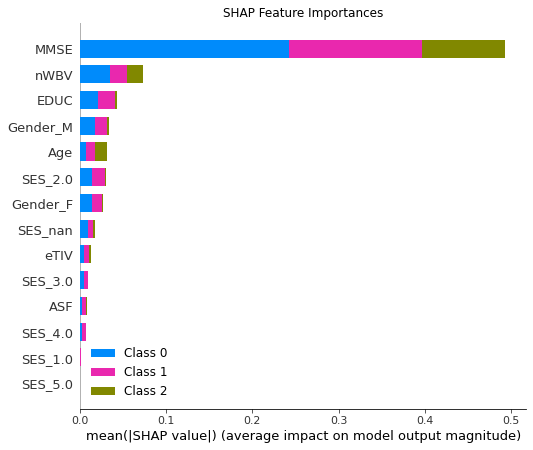

In [238]:
shap.summary_plot(shap_values, final_test_data[0][0],feature_names = feature_names, show=False)
plt.title('SHAP Feature Importances')
plt.savefig("../figures/reportfigs/shap.png", bbox_inches='tight', dpi=300)

In [219]:
# save the output
file = open('../results/feature_importances.save', 'wb')
pickle.dump((feature_names, feat_imp_mean, feat_imp_stdev, perm_imp_mean, perm_imp_std, shap_values),file)
file.close()